# The Echo Chamber Effect - A Case Study (provisional title)

## Milestone 2

In this notebook we will download a small sample of the Reddit dataset for the first time and perform some basic statistics on it. We will talk about the structure of the data, our pipepline to handle it and how this new knowledge has affected our plans for the project.

We will also load the two recommended NLP libraries and try them out to see how they work and to which extent we can take advantage of them.

The full report can be found on the updated README.

In [115]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
%matplotlib inline

import cairo #For the graphs visualizations
from igraph import *

import random

import findspark
findspark.init(r'C:\Spark\spark-2.3.2-bin-hadoop2.7')
#findspark.init('/Users/vikalpkamdar/opt/spark')
#findspark.init()
findspark.find()

from datetime import datetime
from matplotlib import pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlc = SQLContext(sc)

In [116]:
DATA_DIR = './data/'

## Sampling the data

This dataset is big beyond comprehension. Around 2TB of comments from Reddit's inception in 2005 until March 2017. Our machines cannot handle such numbers and even if they could it would take too much time. Instead, we decided to, for now, focus only on 2016 (the year of the US presidential election) which itslef represents already more than 360GB of data and sticked to the following pipeline:

 - Sample 10% of the data (~12GB compressed)
 - Try our scripts locally using spark
 - Once prototyped, upload the scripts to the cluster, run them on the whole year of data and retrieve only the essential parts

This way we streamlined the queries to the cluster and created an easily expandable workframe.

In order to filter and reduce even more the size of the datasets we dropped the columns that mostly have no use for us, namely: ```author_flair_class```, ```author_flair_text```, ```distinguished```, ```edited```, ```retrieved_on```, ```stickied``` and ```subreddit_id```. (Script used on cluster: `script/drop_col.py`)

We don't think a dataset as rich as this needs much enrichment, but we could consider using web scrapping techniques to retrieve subredit data (e.g. the rules of the subreddit).

### Using the sample to explain the data

The following code does not really need the data in its size as it's for explanatory purposes. The queries and operations were performed on our local system with 1% 2016 reddit comments. Once we figured out the querries we applied them to 10% of the 2016 reddit data (~12GB compressed) by sending python scripts (found in scripts/ folder) to the cluster.

In [3]:
df_spark = spark.read.parquet(DATA_DIR + "sliced_2017_posts.parquet")

In [4]:
# Sample size
df_spark.count() # number of comments used for the 1% dataset.

28212401

Firstly we show the column names of the spark data frame and the first row in order to analyze how the data frame is structured, the differents columns and its meanings:

In [14]:
df_spark.columns

['author',
 'subreddit',
 'id',
 'body',
 'created_utc',
 'score',
 'controversiality',
 'pos_sent',
 'neg_sent',
 'neut_sent',
 'compound_sent',
 'post_length']

In [15]:
# example of 1 comment
df_spark.show(1)

+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
|author|     subreddit|     id|                body|created_utc|score|controversiality|pos_sent|neg_sent|neut_sent|compound_sent|post_length|
+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
|ablaaa|syriancivilwar|d19th0x|Not official. See...| 1458690378|    1|               0|     0.0|     0.0|      1.0|          0.0|         41|
+------+--------------+-------+--------------------+-----------+-----+----------------+--------+--------+---------+-------------+-----------+
only showing top 1 row



Here we explain the columns one by one:
* __'author':__ Redditor username
* __'author_flair_css_class':__ CSS class, defines the style of the 'author_flair_text' tag within the html of Reddit.
* __'author_flair_text':__  A tag associated to your username, which is only visible in the current subreddit. 
* __'body':__ The content of the comment.
* __'controversiality':__ When its value is 1, the comment has been voted above a certain threshold and has roughly the same amount of downvotes and upvotes. 0 Otherwise. [More info](https://www.reddit.com/r/redditdev/comments/29i58s/reddit_change_api_availability_controversiality/)
* __'created_utc':__ Unix timestamp of the creation date.
* __'distinguished':__ If a comment is distinguished, this means that a moderator or admin of the subreddit has highlighted it (A little [M] will appear next to it).
* __'edited':__ Indicates if the comment has been edited. If it has not been edited the variable is False, else its value is the Unix Timestamp of the last edition.
* __'gilded':__ When its value is 1, that means a [premium](https://www.reddit.com/premium/) user gave the author [reddit gold](https://www.reddit.com/coins/) (a week of reddit premium). 
* __'id':__ Unique ID of the comment.
* __'link_id':__ Id of the link (similar to post) this comment is anwering to. Always begins with 't3_'.
* __'parent_id':__ Id of the post this comment is below. Always begins with 't3_'.
* __'retrieved_on':__ Unix Timestamp of the comment retrieval (to this data set).
* __'score':__ Upvotes minus downvotes (Reddit mildly obfuscates this value when the comment has lots of votes as a security measure against external meddling. This is called [vote fuzzing](https://www.reddit.com/r/firstdayontheinternet/comments/30b44n/could_someone_explain_how_the_reddit_karma_system/).
* __'stickied':__ Boolean value. When a comment is stickied (by a moderator or admin), the comment appears as the first entry right below the original post.
* __'subreddit':__ Name of the subreddit where the comment was posted.
* __'subreddit_id':__ Unique ID (or full name as refered to in the Rddit API) of the subreddit. Note that those always begin with 't5_'.

The types of each column:

In [16]:
df_spark.distinct()

DataFrame[author: string, subreddit: string, id: string, body: string, created_utc: bigint, score: bigint, controversiality: bigint, pos_sent: string, neg_sent: string, neut_sent: string, compound_sent: string, post_length: string]

And the different values of some of the columns (only the relevant ones):

In [17]:
df_spark[['controversiality']].distinct().show(4)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



In [18]:
df_spark[['distinguished']].distinct().show(4)

AnalysisException: "cannot resolve '`distinguished`' given input columns: [author, controversiality, id, score, neut_sent, subreddit, pos_sent, neg_sent, created_utc, compound_sent, body, post_length];;\n'Project ['distinguished]\n+- Relation[author#87,subreddit#88,id#89,body#90,created_utc#91L,score#92L,controversiality#93L,pos_sent#94,neg_sent#95,neut_sent#96,compound_sent#97,post_length#98] parquet\n"

In [ ]:
df_spark[['edited']].distinct().show(2)

In [ ]:
df_spark[['link_id']].distinct().orderBy(desc("link_id")).show(3)

In [ ]:
df_spark[['score']].orderBy(asc('score')).show(3)

Number of subreddits in our 1% sample:

In [ ]:
df_spark[['subreddit_id']].distinct().count()

Number of controversial comments in our 1% sample:

In [ ]:
df_spark.filter('controversiality = 1').count()

For most of the local processing we will use pandas as it is easier. By the time our data pieces will be filtered and small enough to not run into memory constraints. Using pyarrow we can read parquet files directly into pandas dataframes.

conda install pyarrow, we get an error if we try to transform the spark dataframe

In [5]:
df_pd = pd.read_parquet(DATA_DIR + "sliced_2017_posts.parquet")

We will now print out some basic properties and stats about our 1% data sample.

In [ ]:
df_pd.head(2)

In [ ]:
df_pd[['controversiality', 'distinguished', 'edited', 'parent_id']].values

In [ ]:
df_pd.shape

In [ ]:
len(df_pd['id'].unique())

From the two cells above we can confirm that the `id` is unique.

In [ ]:
df_pd['subreddit'].value_counts().to_frame().hist(bins=[10,100,1000,2000,3000,10000]);

As we can see from the histogram above, a lot of the subreddits have only 1 comment. Hence these subreddits will be considered as outliers, as we feel they do will not help us in our eco-chamber calculations.

We need to decide a threshold for the number of comments per subreddit. Subreddits below that threshold will not bring us much if not any information in our calculations for milestone 3.

In [ ]:
df_pd.dtypes

### Statistics on the cluster

In this part we show what we can do some of the above operations on a bigger dataset (10% of the 2016 reddit comments). Firstly we will show the functions we will use to obtain simple statistics. In the next part we will export these commands onto a python script (script/stats.py) and run them on the 10% sampled 2016 reddit comments.

The stats below are done on the 1% sample of the 2016 reddit comments. But they were just done in order to find the right functions.

In [ ]:
total_n_comments = df_spark.count()
total_n_comments

First we compute the number of removed comments (A comment has been removed when its body is "[deleted]")

In [ ]:
n_deleted_comments = df_spark.filter('body = "[deleted]"').count()
n_deleted_comments 

The percentage of comments that are "removed" according to the above criteria.

In [ ]:
percentage_deleted_comments = 100 * n_deleted_comments  / total_n_comments
percentage_deleted_comments

And the number of comments posted by removed users (Users who have removed their account after post the comment)

In [ ]:
comments_by_removed_users = df_spark.filter('author = "[deleted]"').count()
comments_by_removed_users

The percentage of comments that were posted by "removed" users according to the above criteria.

In [ ]:
percentage_by_dl_user = 100 * comments_by_removed_users / total_n_comments
percentage_by_dl_user

Now we see the total number of controversial comments and the percentage of them:

In [ ]:
n_controversial_comments = df_spark.filter('controversiality = 1').count()
n_controversial_comments

In [ ]:
perc_controversial_comments = 100 * n_controversial_comments / total_n_comments
perc_controversial_comments

Having easily computed this percentages, we now get a dataframe with the number of comments per subrredit in order to plot the distribution:

In [ ]:
#Total number of subreddits:
df_spark[['subreddit']].distinct().count()

In [ ]:
df_subreddit_count = df_spark.groupBy('subreddit').agg(count('*')).withColumnRenamed('count(1)', 'Number of comments')
df_subreddit_count

In [ ]:
df_subreddit_count.show(2)

We have not analyzed the statistics above as they are merely there for us to find the right functions to use wth the cluster.

We will now show the stats with a bigger dataset (10% of the 2016 reddit comments).

The pipeline we used is the following:
1. We first read all of the data in the 2016 .bz2 compressed files and sampled 10% of it to run our querries with the cluster (`script/read_data_original.py`)
2. We then sampled another 10% to obtain 1% of the 2016 reddit comments that we played with above (`scripts/read_data.py`)
3. Once we found the correct form for our querries on the smaller dataset, we ran them with cluster on the larger dataset (`scripts/`) and saved them to smaller sized parquet files.
4. We then imported these smaller parquet files into our local machine and read them and transformed them to pandas dataframes in order to plot the graphs.

The above stats were obtained using `scripts/stats.py` with cluster. The stats were saved in a text file (`data/stats.txt`). 

Total number of comments: 79998223  
Number of deleted comments: 3414381  
% of deleted comments: 4  
Number of comments by removed users: 5706216  
% comments by deleted users: 7  
Number of controversial comments: 1770571  
% of controversial comments: 2  
Number of subreddits: 131028  

We first decided to have a look at the number of querries per subreddit (`scripts/stats.py`)

In [ ]:
df_subreddit_count = spark.read.parquet(DATA_DIR + 'df_subreddit_count.parquet')

In [ ]:
df_subreddit_count.show(3)

In [ ]:
df_subreddit_count.toPandas().shape

Let us now plot the 10 most 'popular' (commented) subbreddits. As they are the ones to give us the most information in our future calculations.

In [ ]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = False).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments",legend = None)
plt.title('10 most popular (commented) subbreddits')
plt.xlabel('number of comments');
plt.ylabel('subreddits');

And now 10 least popular subreddits, as they will potentially be removed.

In [ ]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = True).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments", legend = None);
plt.title('10 least popular subreddits')
plt.xlabel('number of comments');

As we can see the last 10 all have exactly 1 comment.

Let us now try to see how many subreddits have 1 comment.

In [ ]:
df_subreddit_count_pd = df_subreddit_count.toPandas()

In [ ]:
n_subreddits_per_comment = df_subreddit_count_pd.groupby('Number_of_comments').count()

In [ ]:
n_subreddits_per_comment.head()

In [ ]:
n_subreddits_per_comment.hist(bins = [1,10,100,1000]);
plt.title('Histogram showing the comment frequecy');

As we can see a lot of the subreddits have 1 comment, hence removing these will reduce the size of our dataset.

Let us now analyze the controversiality of the comments (`script/stats.py`)

In [ ]:
df_controversial_per_subr_count = spark.read.parquet(DATA_DIR + "df_controversial_per_subr_count.parquet")
df_controversial_per_subr_count.show(2)

In [ ]:
df_controversial_per_subr_count_pd = df_controversial_per_subr_count.toPandas()

10 most controversial subreddits

In [ ]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=False).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend=None);
plt.title('10 most controversial subreddits');
plt.xlabel('Number of controversial comments');

10 least controversial subreddits

In [ ]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=True).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend = None)
plt.title('10 least controversial subreddits');
plt.xlabel('number of controversial comments');

In [ ]:
df_controversial_per_subr_count_pd.groupby('N_controversial_comments').count().hist(bins=[1,10,100,1000])

As we can see in the graph for most popular subbreddits (comments and controversial comments), some of the most popular subreddits are also some of the most controversial ones (askreddit, worldnews, politics,...) Hence there might be a correlation between the number of comments and controversiality.

In [ ]:
df_corr_contr_comm.show(3)

In [ ]:
df_corr_contr_comm.corr("N_controversial_comments","Number_of_comments")

We see there is a correlation between popularity and controversiality, what could be a good factor for our analysis of the echo-chambing effect.

Let us now plot a stacked bar chart to see the ratio of controversial to non controversial comments per subreddits.

In [ ]:
df_created_utc = spark.read.parquet(DATA_DIR + "df_comments_per_month.parquet")

In [ ]:
df_created_utc_pd = df_created_utc.toPandas()

In [ ]:
df_created_utc_pd = df_created_utc_pd.iloc[:12,:].merge(df_created_utc_pd.iloc[12:,:], right_on = 'count', left_on = 'count')
df_created_utc_pd = df_created_utc_pd[['month_y','month_x','count']]
df_created_utc_pd.columns = ['month_int','month_string','n_of_comments']
df_created_utc_pd = df_created_utc_pd.sort_values(by='month_int',ascending=True)

In [ ]:
df_created_utc_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_controversial.parquet")

In [ ]:
df_created_utc_controversial_pd = df_created_utc_controversial.toPandas()
df_created_utc_controversial_pd.sort_values(by="month",ascending=True)
df_created_utc_controversial_pd.columns = ['month_int','n_of_controversial']

In [ ]:
df_created_utc_non_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_non_controversial.parquet")

In [ ]:
df_created_utc_non_controversial_pd = df_created_utc_non_controversial.toPandas()
df_created_utc_non_controversial_pd = df_created_utc_non_controversial_pd.sort_values(by='month',ascending=True)
df_created_utc_non_controversial_pd.columns = ['month_int','n_of_non_controversial']

In [ ]:
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_controversial_pd,left_on='month_int',right_on = 'month_int')
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_non_controversial_pd,left_on='month_int',right_on = 'month_int')

In [ ]:
df_created_utc_pd

In [ ]:
df_created_utc_pd[['n_of_controversial','n_of_non_controversial']].plot(kind='bar', stacked=True);

As we can see for each month in 2016 the number of non controversial comments outweigh the number of controversial comments.

### Natural Language Processing

As a final step wiithin milestone 2, below are our first steps with NLP, basically trying out the sugested libraries. Here's a reference with some more libraries https://elitedatascience.com/python-nlp-libraries

To use this libraries in a simple way and in order to execute queries quickly we are going to study now just the comments of one of the subreddits of the sample, "The_Donald".

In [ ]:
df_nlp = df_pd[df_pd["subreddit"] == "The_Donald"].sample(10000)

In [ ]:
df_nlp.shape

### spaCy

spaCy allows us to find named entities, thus identying the topic(s) of a post or discussion. spaCy can be found here https://spacy.io/ with instructions for installing here https://spacy.io/usage/

In [ ]:
# For the installation: Execute in the anaconda prompt:
# pip install spacy
# python -m spacy download en_core_web_sm #(With admin permissions)
import spacy

spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.

From this library we are going to use the "Named Entity Recognition" functionality:

A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Having done this simple query, let's see which are the usuals named entities of the "The_Donald" subreddit comments. 

Note: We have done this grammatical analysis using the function npl.pipe, in order to make faster the execution.

In [ ]:
tags = []
for doc in nlp.pipe(df_nlp["body"].astype('unicode').values, batch_size=50,
                        n_threads=4):
    if doc.is_parsed:
        tags.append([ent.label_ for ent in doc.ents])


In [ ]:
tags = [val for sublist in tags for val in sublist]  #From a list of lists to a list

In [ ]:
df_npl_pd = pd.DataFrame(tags, columns=["tags"])
tags_count = df_npl_pd.tags.value_counts().sort_values(ascending=False)
tags_count.head(5)

So we see that the most popular tags in this subreddit are  ORG, PERSON, GPE, NORP and DATE. Below you can see the meaning of each tag:
* PERSON	People, including fictional.
* NORP	Nationalities or religious or political groups.
* FAC	Buildings, airports, highways, bridges, etc.
* ORG	Companies, agencies, institutions, etc.
* GPE	Countries, cities, states.
* LOC	Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT	Objects, vehicles, foods, etc. (Not services.)
* EVENT	Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART	Titles of books, songs, etc.
* LAW	Named documents made into laws.
* LANGUAGE	Any named language.
* DATE	Absolute or relative dates or periods.
* TIME	Times smaller than a day.
* PERCENT	Percentage, including "%".
* MONEY	Monetary values, including unit.
* QUANTITY	Measurements, as of weight or distance.
* ORDINAL	"first", "second", etc.
* CARDINAL	Numerals that do not fall under another type.

Finally we plot the appearances of each tag in the sample studied:

In [ ]:
df_tags_count = pd.DataFrame(tags_count).reset_index()
df_tags_count.columns=["Tags", "Appearances"]
df_tags_count.set_index("Tags")

df_tags_count.plot(kind="barh", x = "Tags", y = "Appearances")

### TextBlob

TextBlob allows for sentiment analysis, translation, and more

TextBlob can be found here https://textblob.readthedocs.io/en/dev/ with installation instructions here https://textblob.readthedocs.io/en/dev/install.html

In [ ]:
from textblob import TextBlob

We try the sentiment analysis this library offers:

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
```
 testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
 testimonial.sentiment
 Output: Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)
 testimonial.sentiment.polarity
0.39166666666666666

```

Now let's try to see how is the sentiment analysis of the "The_Donald" subreddit comments. We have added two columns to the original data frame, one with the polarity measured and the other with the other with the subjectivity.

In [ ]:
df_nlp['sentiment_polarity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.polarity)
df_nlp['sentiment_subjectivity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.subjectivity)

In [ ]:
df_nlp.head(2)

Finally, we plot the distribution of both polarity and subjectivity.   

Reminder: The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
df_nlp['sentiment_polarity'].hist()

With the polarity distribution we check that most of the comments usually are no so polarized. However there is a considerable amount of comments polarized. 

In [ ]:
df_nlp['sentiment_subjectivity'].hist()

With the subjectivity distribution we also see that there are lots of comments which are somehow subjectives, although the most common is not being subjective.

# Milestone 3

# Analyzing the echo-chambering effect between subreddits

In [13]:
df_spark = spark.read.parquet(DATA_DIR + "final_dataset_2016_user_sampled_post_filtered.parquet")

In this part we are going to use the data set contained in `final_dataset_2016_user_sampled_post_filtered.parquet`, which contains the comments in the top 200 subreddits in number of comments in 2016, which have not been deleted or removed (their body is not "[deleted]" or "[removed]") and with just the useful columns. We will analyze how the different subreddits are connected, i.e. how the communities that live inside reddit are connected. 

To do this we first consider the number of users who are commenting in the different subreddits as a measure of the connection between the subreddits. For example: Given two subreddits `subreddit1` and `subreddit2`, their connection would be as great as much users are commenting in both subreddits.

## Connection between subreddits

So, our first step is to obtain this value (number of users commenting in both subreddits) which measures the size of the connection between every pair of subreddits. We are going to compute this value in an adjacency matrix (since it seems like an ntuitive way of storing this information)

In [316]:
df_subreddit_users = df_spark.select('subreddit','author','id').groupby('subreddit') \
                                .agg(collect_set('author').alias('users'),count('id').alias('number_of_comments')) \
                                .filter('number_of_comments > 1000') \
                                .orderBy(asc('subreddit'))

df = df_subreddit_users.toPandas()  #Used in next subsection

adjacency_matrix = np.zeros([df.shape[0],df.shape[0]])

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if i == j:
            adjacency_matrix[i,j] = 0
        else:
            subb1_users = set(df.iloc[i]['users'])
            subb2_users = set(df.iloc[j]['users'])
            n_common_users = len(subb1_users.intersection(subb2_users))
            adjacency_matrix[i,j] = n_common_users

df_adj = pd.DataFrame(adjacency_matrix)

In [317]:
#List of subreddits
subreddit_list = df["subreddit"].tolist()
#Name the columns and the rows
df_adj.columns = subreddit_list
df_adj["subreddits"] = df["subreddit"]
df_adj.set_index("subreddits", inplace = True)
df_adj.head(4)

,2007scape,4chan,AdviceAnimals,Amd,Android,AskMen,AskWomen,BabyBumps,BigBrother,Bitcoin,...,tifu,todayilearned,trees,ukpolitics,unitedkingdom,videos,whowouldwin,worldnews,wow,xboxone
subreddits,,,,,,,,,,,,,,,,,,,,,
2007scape,0.0,471.0,860.0,63.0,273.0,156.0,62.0,5.0,16.0,45.0,...,430.0,1095.0,458.0,80.0,89.0,1121.0,65.0,1035.0,339.0,242.0
4chan,471.0,0.0,4517.0,260.0,1499.0,922.0,361.0,17.0,53.0,233.0,...,2220.0,5762.0,2100.0,363.0,513.0,5481.0,468.0,5544.0,945.0,812.0
AdviceAnimals,860.0,4517.0,0.0,559.0,4151.0,2649.0,1329.0,141.0,221.0,657.0,...,6365.0,21460.0,6250.0,786.0,1162.0,20097.0,822.0,19174.0,2740.0,2498.0
Amd,63.0,260.0,559.0,0.0,460.0,117.0,53.0,3.0,11.0,76.0,...,357.0,861.0,222.0,92.0,114.0,810.0,58.0,948.0,190.0,191.0


So, we can easily interpret this data by seeing in the data frame (`df_adj`) the index and the column (or viceversa). 

For example, in the first row we see that the subreddit `2007scape` is connected with the subreddit `AskMen` by 156 users (there exists 156 users who have commented in both subreddits); in the fourth row we see that `Amd` subreddit is connected with `Android` by 460 users.

#### Visualization 1

As it could not be otherwise, to visualize this data we have chosen a network graph. Because the quantity of nodes is big we have used a library called ggplot2 in R. You can see the code used for obtaining the graph in the notebook `./reddit-graph-visualizations-r/subreddit_network_pdf` based on the notebook of Max Woolf (@minimaxir): See it on [GitHub](https://github.com/minimaxir/reddit-graph).

To run this notebook we have computed the edge list from the adjacency matrix, as its preferred as a data structure for storing and representing graphs:

In [197]:
edge_list = pd.DataFrame([[subreddit_list[0], subreddit_list[1], adjacency_matrix[0,1]]], columns = ["Subreddit1", "Subreddit2", "Weight"])
n_subreddits = len(subreddit_list)

for i in range(n_subreddits):
    for j in range(i+1, n_subreddits):
        df_tmp = pd.DataFrame([[subreddit_list[i], subreddit_list[j], adjacency_matrix[i,j]]] , columns = ["Subreddit1", "Subreddit2", "Weight"])
        edge_list = edge_list.append(df_tmp, ignore_index=True)

edge_list.head(2)

,Subreddit1,Subreddit2,Weight
0,2007scape,4chan,471.0
1,2007scape,4chan,471.0


We have deleted the edges with few weight connections (otherwise the graph is not appreciable)

In [97]:
edge_list_filt = edge_list.copy()
mean = edge_list_filt["Weight"].mean()
print(mean)
#edge_list_filt["Weight"] = edge_list_filt["Weight"].apply(lambda x: 0 if x < 15 else x) #Removing soft links for seeing a better graph (weights to 0)
edge_list_filt.drop(edge_list_filt[edge_list_filt.Weight < 900].index, inplace = True) #Removing soft links for seeing a better graph (remove edges)

885.5705240942666


Finally export it into a `.csv` file and run the other notebook (manually because it is in R, not python)

In [98]:
#edge_list_filt["Weight"] = edge_list["Weight"] * 100 #To do a clearly visualization
edge_list_filt.set_index("Subreddit1", inplace = True) #In order to not export the indexes to the .csv
edge_list_filt.to_csv("./reddit-graph-visualizations-r/" + 'edge_list.csv')

In [106]:
from IPython.display import IFrame
IFrame("./reddit-graph-visualizations-r/subreddit-1.svg", width=800, height=400)

This visualization do not seems to be very useful right now for study the echo-chambing; however we will use this kind of graph in the last section of our project, when studiying the ideology of the usual users of every subreddits.

Note: Default subreddits in this graph have been chosen manually; this graph is just a previous to the final one (in which the nodes are colored in terms of their "conservative-ideology vs liberal-ideology")

## Echo-chambing effect between political subreddits

As finally our project has been conceived as a political study, and considering that one of the main problem for study and interpret our data is the amount of subreddits, we are going to focus on the political subreddits (that are in the 200 greatest subreddist set):

In [318]:
df_topics = pd.read_parquet(DATA_DIR + "topics.parquet")
political_subreddits = df_topics[df_topics["topic"] == "politics"]["subreddit"].tolist()
political_subreddits

['conspiracy',
 'politics',
 'hillaryclinton',
 'SandersForPresident',
 'PoliticalDiscussion',
 'EnoughTrumpSpam',
 'ukpolitics',
 'The_Donald']

We extract the new edge list and the new adjacency matrix (with just the political communities data) from the last one:

In [319]:
#Edge list
edge_list_politics = edge_list.loc[(edge_list['Subreddit1'].isin(political_subreddits)) & edge_list['Subreddit2'].isin(political_subreddits)]

In [338]:
#Adjacency matrix data frame
df_politics_adj = df_adj.loc[df_adj.index.isin(political_subreddits)]
political_subreddits = df_politics_adj.index.unique().tolist()  #For get the list in the correct order
df_politics_adj= df_politics_adj[political_subreddits].copy()
df_politics_adj

,EnoughTrumpSpam,PoliticalDiscussion,SandersForPresident,The_Donald,conspiracy,hillaryclinton,politics,ukpolitics
subreddits,,,,,,,,
EnoughTrumpSpam,0.0,1846.0,3960.0,5539.0,2332.0,1854.0,8333.0,413.0
PoliticalDiscussion,1846.0,0.0,3155.0,3038.0,1386.0,1744.0,6681.0,372.0
SandersForPresident,3960.0,3155.0,0.0,9975.0,3654.0,2971.0,16819.0,495.0
The_Donald,5539.0,3038.0,9975.0,0.0,5961.0,2911.0,21723.0,868.0
conspiracy,2332.0,1386.0,3654.0,5961.0,0.0,1155.0,7454.0,401.0
hillaryclinton,1854.0,1744.0,2971.0,2911.0,1155.0,0.0,4865.0,235.0
politics,8333.0,6681.0,16819.0,21723.0,7454.0,4865.0,0.0,1397.0
ukpolitics,413.0,372.0,495.0,868.0,401.0,235.0,1397.0,0.0


Compute the number of different users who have commented in each subreddit:

In [322]:
df_number_of_users = df.copy()
df_number_of_users["number_of_users"] = df_number_of_users["users"].apply(lambda x: len(x))
df_number_of_users.set_index("subreddit", inplace = True)
df_number_of_users.head(2)

,users,number_of_comments,number_of_users
subreddit,,,
2007scape,"[PregnantMale, Mr_Abel, ExtremeWindyGuy, Slaye...",62157,1988
4chan,"[matthewgstat, Boxxi, baconlover24, ChaseDPat,...",69400,8069


And use the igraph library for plot the graph:

#### Visualization 2 (From the edge list)

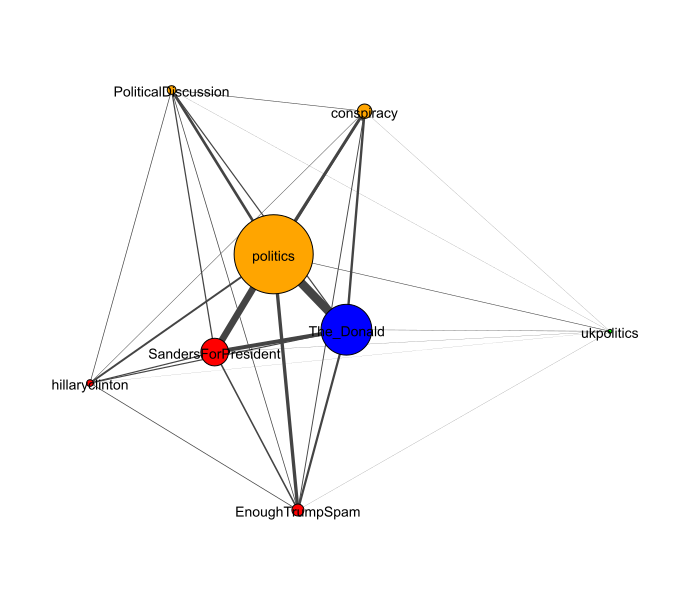

In [383]:
g_politics_undirected = Graph()

to_delete_ids = [v.index for v in g_politics_undirected.vs]
g_politics_undirected.delete_vertices(to_delete_ids)

g_politics_undirected.add_vertices(len(political_subreddits))
g_politics_undirected.vs['label'] = political_subreddits
edg_list = []
for i in range(len(political_subreddits)):
    for j in range(len(political_subreddits)):
        mask = (edge_list_politics["Subreddit1"] == political_subreddits[i]) & (edge_list_politics["Subreddit2"] == political_subreddits[j])
        if len(edge_list_politics[mask]) > 0:
            edg_list = edg_list +[(i,j)]
            
g_politics_undirected.add_edges(edg_list)
g_politics_undirected.es['weight'] = edge_list_politics["Weight"].values

g_politics_undirected.es['widht'] = edge_list_politics["Weight"].values * 0.0004
#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politics_undirected.layout_fruchterman_reingold(weights = g_politics_undirected.es['weight'])

visual_style = {}
visual_style["bbox"] = (700, 600)
visual_style["margin"] = 90
visual_style["vertex_size"] = [df_number_of_users.loc[s]["number_of_users"] * 0.001 for s in political_subreddits]
subreddit_politic_colors = ['red', 'orange', 'red', 'blue', 'orange', 'red','orange', 'green']
visual_style["vertex_color"] = subreddit_politic_colors
  
plot(g_politics_undirected, layout = layout, **visual_style, edge_width = g_politics_undirected.es['widht'])

In this graph:
* The balls size means the number of users who have commented in the respective subreddit.
* The edges width means the number of users who have commented in both subreddits. 
* The layout algorithm (fruchterman_reingold) print the nodes which have less weight connection more distanciated (See more about it: https://github.com/gephi/gephi/wiki/Fruchterman-Reingold).

We can clearly see that the `ukpolitics` subreddit is far away from the others due to its connection greatness is very small. This is obviously because it is the only one which is not focus in USA politics, so we see that there are not so much users who comment about both UK and USA politics.

On the other hand we see that the `politics` is the most connected subreddit followed by `The_Donald`. So what we conclude is that the subreddits which have more users usually have more users in common with the others what makes sense. Unfortunately this is not revealing anything about the echo-chambing effect.

So, let´s see what happens if we consider the greatness of the subreddit when we assign the edges width, i.e. if we now plot a directed graph in which the width of every edge is assigned in terms of the number of users in both origin and destination subreddits divided by the total number of users in the origin; so computing the percentage of users who have commented in the origin subreddit who have also commented in the destination:

### Edges width ~ Percentage of users of the origin subreddit who have also commented in the destination subreddit
First let's compute the new adjacency matrix; as we have described previously, now the weights are `Number_of_users_commenting_in_both/Number_of_users_commenting_in_origin`

In [386]:
df_for_total_users = df.set_index("subreddit")

df_politics_adj_percentages = df_politics_adj.copy()
for i in df_politics_adj_percentages.index:
    total_users = len(df_for_total_users.loc[i].users)
    df_politics_adj_percentages.loc[i] = df_politics_adj_percentages.loc[i] / total_users * 100
df_politics_adj_percentages

,EnoughTrumpSpam,PoliticalDiscussion,SandersForPresident,The_Donald,conspiracy,hillaryclinton,politics,ukpolitics
subreddits,,,,,,,,
EnoughTrumpSpam,0.000000,15.388463,33.011004,46.173725,19.439813,15.455152,69.464822,3.442814
PoliticalDiscussion,21.328712,0.000000,36.452917,35.101098,16.013865,20.150202,77.192374,4.298094
SandersForPresident,14.330692,11.417508,0.000000,36.098144,13.223320,10.751638,60.865632,1.791336
The_Donald,10.910416,5.984084,19.648204,0.000000,11.741648,5.733927,42.788765,1.709738
conspiracy,16.224866,9.643081,25.422668,41.473596,0.000000,8.035901,51.861129,2.789953
hillaryclinton,27.622169,25.983313,44.264005,43.370083,17.207986,0.000000,72.482122,3.501192
politics,10.536098,8.447338,21.265647,27.466178,9.424706,6.151220,0.000000,1.766342
ukpolitics,10.522293,9.477707,12.611465,22.114650,10.216561,5.987261,35.592357,0.000000


Now we have more interesting data for the echo-chambing effect study!  
Analyzing the data frame row by row, each row contains the percentage of people who have commented in both the index and the column subreddit (of this row) respective to the peoplewho have commented in the index subreddit; i.e.   
`%(i,j)=users_commenting_in(i_subreddit,j_subreddit)/users_commenting_in(i_subreddit)` where i refers to the row and j to the column.

In [404]:
 A_perc[A_perc.nonzero()].mean()

22.167321254896528

So we see that the percentage of people who have commented in two determined subreddits usually is very small (less than 25%). Considering that we are working with all the comments posted in these subreddits during 2016, this means that the different political communities (subreddits) in Reddit are not usually very well connected, at least not those which were in the top 200 greatest communities in 2016. Assuming that there exists echo chambing effect inside any of this subreddits, then we have proved that the echo chambing effect is affecting the users of this community in the whole Reddit, since these users are not interacting so much with other communities. 

In order to strengthen this fact (that the political communities are not well connected), we compute the percentage of people who have comment in more than one of these subreddits:

In [416]:
len(df_users_politic.loc["The_Donald"]["users"])

50768

In [420]:
df_users_politic = df_number_of_users.loc[political_subreddits].copy()
total_users = 0
users_in_more_1_subr = 0  #Users who have commented in more than one subreddit
for i in range(len(political_subreddits)-1):
    for u in df_users_politic.loc[political_subreddits[i]]["users"]:
        isin_other_subreddit = False
        for j in range(i+1, len(political_subreddits)):
            if u in df_users_politic.loc[political_subreddits[j]]["users"]:
                isin_other_subreddit = True
                df_users_politic.loc[political_subreddits[j]]["users"].remove(u)
        if isin_other_subreddit:
            users_in_more_1_subr = users_in_more_1_subr+1
        total_users = total_users +1

print(users_in_more_1_subr/total_users) 

0.14041382346467093


Just the 14% of the users who commented in one of the political subreddits have commented in more than one! This fact strengthen our claim and so we can reasset that the political communities inside reddit are not well-connected (there are not so much interactions between them).

Finally, with these data we can also analyze which of these political subreddits is interacting more or less with the others (and so in which of the communities our claim is strongest). We do that after plot the visualization:

#### Visualization 3 

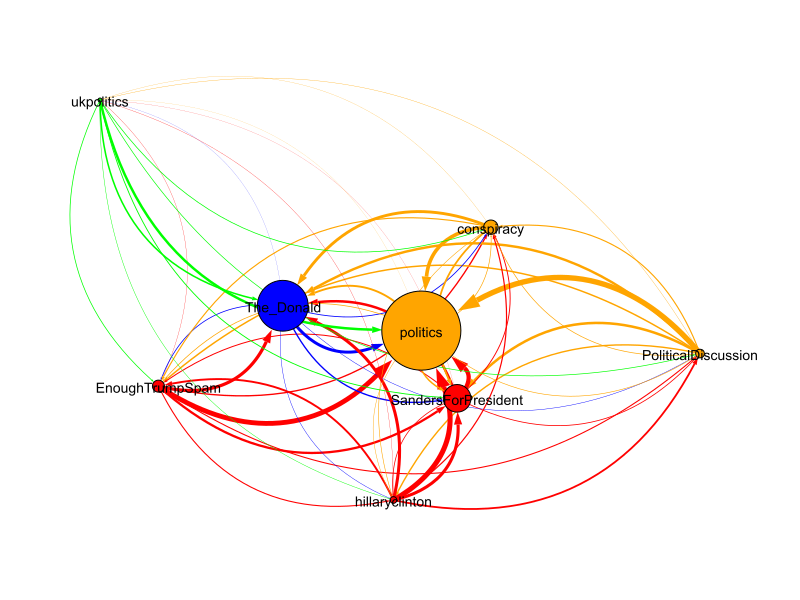

In [400]:
A_perc = df_politics_adj_percentages.values
g_politics_subreddits_2 = Graph().Adjacency((A_perc > 0).tolist())
# Add edge weights and node labels.
g_politics_subreddits_2.es['weight'] = A[A.nonzero()]
g_politics_subreddits_2.vs['label'] = political_subreddits
g_politics_subreddits_2.es['widht'] = A_perc[A_perc.nonzero()] *0.07

visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 100
visual_style["vertex_size"] = [df_number_of_users.loc[s]["number_of_users"] * 0.001 for s in political_subreddits]
visual_style["edge_arrow_size"] = A_perc[A_perc.nonzero()] * 0.02
visual_style["vertex_color"] = subreddit_politic_colors

edges_colors = []
edge_list = g_politics_subreddits_2.get_edgelist()
for edge in edge_list:
    edges_colors = edges_colors + [subreddit_politic_colors[edge[0]]]
    
visual_style["edge_color"] = edges_colors

#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politics_subreddits_2.layout_fruchterman_reingold(weights = g_politics_subreddits_2.es['weight'])  
plot(g_politics_subreddits_2, **visual_style, layout = layout, edge_width = g_politics_subreddits_2.es['widht'])

In this graph:
* The edges width is proportional to the percentage of users of the origin subreddit who have also commented in the destination subreddit.
* The edges color is the color of the subreddit origin (the color of the ball representing the subreddit).
* Balls size and layout algorithm same as the last one. Note that the layout do not work proporcionable (as the edges width)

As we have seen just before the visuzalization, the connection between these subreddits is soft (there are few users in proportion commenting in two determined subreddits). Now the size of the subreddits is not influencing the measure of the connection between then; so we see that there are not such differences in the edges width comparing with the previous visualization. 

This graph allows us to compare how are the interactions of the different subreddits with the others and deduct some conclusions: 
* We can see that the edges who born in the `The_Donald` subreddit (the blue ones) are very thin in comparision with the others, and that his widthest edge is that whose origin is `Politics`, but it is still thin. So we can interpret that if there is echo-chambing in `The_Donald` subreddit (indeed is well-known that there exits echo-chambing in this subreddit, just see its rules), then most of their users would be totally effected by echo-chambing (inside Reddit), since the percentage of them who interact with other subreddits is very low.
* The `politics` subreddit is the one which receive as origin the widthest edges. We could think that this is because of its size; however the `The_Donald` subreddit do not have such width edges. So we can conclude that the `politics` subreddit is the one such that the other ones interact the most with. 
* We see a problem when interpreting some of the results, since we do not know which community is interacting with the other; so we see the necessity of classify the people between the communities. Even though we know that one user can belongs to more than one community, we are going to try to guess which of them is the prefered by each user (see next step).

### Last step - Classifying users by their main community

Next step is to try to classify the users main subreddit. Assuming that every of these subreddits have their own "personality" and features, we are going to determine which of them represents better is the prefered of every user (with the idea of interpret that a certain subreddit owns a certain number of users). 

For doing that we are going to see in which of the subreddits the user has more score (meaning this that the user opinion is well or bad accepted by the general opinion of the subreddit) and by the number of comments posted in each subreddit (it is normal to thing that people who usually post in an specific subreddit is close to the way of thinking of general people in this subreddit; else this user could be revealed by the score of his comments!) 

Let's obtain first a data frame with all the neccesary data. First we extract a list with all the users which have posted commments in some of these subreddits:

In [424]:
users_list = []
for u in df_users_politic["users"]:
    users_list = users_list + u
    
users_list = list(set(users_list)) #Drop duplicates
len(users_list)

48575

So, we have to classify every user of this list. The idea is to for every user and for each political subreddit determine a value which means the grade of belonging to it; finally we classify the user according to the gratest value. If there is a tie we add this user to both(or more) kinds of user:


Note: Every comment posted in a certain subreddit add +1 point for belonging to it. The score is just added (do not mater if it is positive or negative). With this way of classification we are giving more importance to the score (in case there are great values).

In [426]:
#We use the original data frame in order to get the score and the number of comments in each political subreddit!!
df_spark.select("author", "score", "subreddit").write.mode('overwrite').parquet(DATA_DIR + "temp1.parquet")
df_pd2 = pd.read_parquet(DATA_DIR + "temp1.parquet")

In [435]:
#We are going to classify just a certain number of user (chosen randomly) and extrapolate these results to the vizualizations.
n_users_to_classify = 5000
users_list_s = random.sample(users_list, n_users_to_classify)
df_classifying = df_pd2.loc[df_pd2["subreddit"].isin(political_subreddits) & df_pd2["author"].isin(users_list_s)]

In [ ]:
df_classifying.shape #Almost 1,5 million comments written by 20000 different users

(360092, 3)

In [ ]:
df_classifier = pd.DataFrame(index = political_subreddits)
df_classifier["Users_list"] = [list() for x in range(len(df_classifier.index))]

for u in users_list_s:
    subreddit_values = np.zeros(len(political_subreddits))
    df_user_comments = df_classifying[df_classifying["author"] == u]
    for index, row in df_user_comments.iterrows():
        value = 1
        value = value + row.score
        sreddit_index = political_subreddits.index(row.subreddit)
        subreddit_values[sreddit_index] = subreddit_values[sreddit_index] + value
    greatest_value = subreddit_values.max()
    for i in range(len(subreddit_values)):         #Neccesary in case there is a tie
        if(greatest_value > 0 and subreddit_values[i] == greatest_value):
            df_classifier["Users_list"].loc[political_subreddits[i]] = df_classifier["Users_list"].loc[political_subreddits[i]] + [u] 
    

In [ ]:
df_classifier["Number_of_Users_Belonging"] = [len(i) for i in df_classifier["Users_list"]]
df_classifier

With the classification done, it is time to do the last graph of this kind:

First we need a new adjacency matrix, where the value in the position subreddit1-subreddit2 mean the quantity of users who are from the subreddit1-ideology and who have posted in the subreddit2. (For compute this matrix we use the dataframe `df` obtained at the beginning of this section, which have the list of users who have posted in each subreddit):

In [103]:
df.set_index("subreddit", inplace = True)
df.head(2)

,users,number_of_posts
subreddit,,
2007scape,"[PregnantMale, Mr_Abel, ExtremeWindyGuy, Slaye...",62157
4chan,"[matthewgstat, Boxxi, baconlover24, ChaseDPat,...",69400


In [104]:
df_pol_final = df_politics_adj.copy()
for i in df_pol_final.index:
    for j in df_pol_final.columns:
        if i == j:
            df_pol_final.loc[i][j]=0
        else:
            df_pol_final.loc[i][j] = len(list(set(df_classifier.loc[i]["Users_list"]) & set(df.loc[j]["users"])))

In [105]:
df_pol_final

,EnoughTrumpSpam,PoliticalDiscussion,SandersForPresident,The_Donald,conspiracy,hillaryclinton,politics,ukpolitics
subreddits,,,,,,,,
EnoughTrumpSpam,0.0,31.0,85.0,142.0,54.0,55.0,236.0,10.0
PoliticalDiscussion,53.0,0.0,77.0,54.0,25.0,39.0,232.0,7.0
SandersForPresident,97.0,80.0,0.0,324.0,102.0,113.0,730.0,7.0
The_Donald,306.0,135.0,599.0,0.0,378.0,172.0,1515.0,36.0
conspiracy,42.0,23.0,86.0,166.0,0.0,10.0,267.0,9.0
hillaryclinton,35.0,38.0,52.0,30.0,9.0,0.0,94.0,1.0
politics,650.0,576.0,1307.0,1407.0,525.0,371.0,0.0,69.0
ukpolitics,15.0,14.0,15.0,48.0,15.0,6.0,83.0,0.0


In [106]:
df_politics_adj_classified = df_pol_final
for i in df_politics_adj_classified.index:
    total_users = df_classifier.loc[i]["Number_of_Users_Belonging"]
    df_politics_adj_classified.loc[i] = df_politics_adj_classified.loc[i] / total_users * 100

In [107]:
df_politics_adj_classified

,EnoughTrumpSpam,PoliticalDiscussion,SandersForPresident,The_Donald,conspiracy,hillaryclinton,politics,ukpolitics
subreddits,,,,,,,,
EnoughTrumpSpam,0.000000,4.952077,13.578275,22.683706,8.626198,8.785942,37.699681,1.597444
PoliticalDiscussion,11.064718,0.000000,16.075157,11.273486,5.219207,8.141962,48.434238,1.461378
SandersForPresident,4.549719,3.752345,0.000000,15.196998,4.784240,5.300188,34.240150,0.328330
The_Donald,5.453573,2.405988,10.675459,0.000000,6.736767,3.065407,27.000535,0.641597
conspiracy,3.849679,2.108158,7.882676,15.215399,0.000000,0.916590,24.472961,0.824931
hillaryclinton,12.195122,13.240418,18.118467,10.452962,3.135889,0.000000,32.752613,0.348432
politics,7.330551,6.495996,14.740047,15.867825,5.920830,4.184053,0.000000,0.778166
ukpolitics,3.529412,3.294118,3.529412,11.294118,3.529412,1.411765,19.529412,0.000000


#### Visualization 4

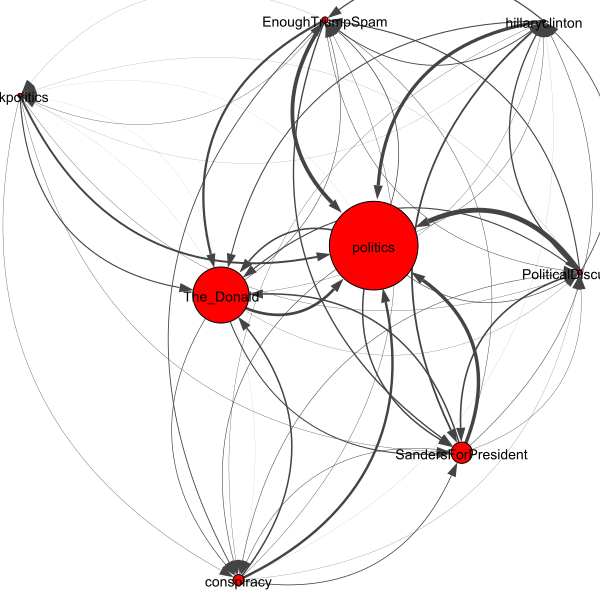

In [110]:
A_classified = df_politics_adj_classified.values
g_politic_subreddits_3 = Graph().Adjacency((A_classified > 0).tolist())
# Add edge weights and node labels.
g_politic_subreddits_3.es['weight'] = A_classified[A_classified.nonzero()]
g_politic_subreddits_3.vs['label'] = politic_subreddits
g_politic_subreddits_3.es['widht'] = A_classified[A_classified.nonzero()] *0.1


visual_style = {}
visual_style["bbox"] = (800, 600)
visual_style["margin"] = 100
visual_style["vertex_size"] = [df_classifier.loc[s]["Number_of_Users_Belonging"] * 0.01 for s in politic_subreddits]
visual_style["edge_arrow_size"] = A_perc[A.nonzero()] * 0.02
visual_style["vertex_color"] = subreddit_politic_colors
visual_style["edge_color"] = edges_colors

#What this algorithm (fruchterman_reingold) do is printing the nodes which have less weight connection more distanciated
layout = g_politic_subreddits_3.layout_fruchterman_reingold(weights = g_politic_subreddits_3.es['weight'])  
plot(g_politic_subreddits_3, **visual_style, layout = layout, edge_width = g_politic_subreddits_3.es['widht'])

In [18]:
political_subreddits_1 = df_topics[df_topics["topic"] == "politics"]["subreddit"].tolist()
edge_list_politics = edge_list.loc[(edge_list.index.isin(political_subreddits_1)) & edge_list['Subreddit2'].isin(political_subreddits_1)]

In [19]:
#edge_list_politics.to_csv(DATA_DIR + 'edge_list.csv')

### Now let's see what are the subreddits which are more connected with other subreddits (whose users post also in other subreddits)


In [88]:
df_centralized = pd.DataFrame(index = subreddit_list, columns = ['Centralized_value']) 
for i in range(n_subreddits):
    centralized_value = 0
    for j in range(0, n_subreddits):
        centralized_value = centralized_value + adjacency_matrix[i,j]
    df_centralized.loc[subreddit_list[i]] = centralized_value
    
df_centralized.head(3)

,Centralized_value
2007scape,46508
4chan,224855
AdviceAnimals,687396


In [89]:
df_centralized.sort_values('Centralized_value', ascending = False).head(30).index

Index(['politics', 'pics', 'funny', 'todayilearned', 'worldnews', 'videos',
       'news', 'gifs', 'gaming', 'movies', 'Showerthoughts', 'AdviceAnimals',
       'WTF', 'The_Donald', 'IAmA', 'mildlyinteresting', 'aww', 'technology',
       'television', 'nottheonion', 'Music', 'explainlikeimfive',
       'SandersForPresident', 'LifeProTips', 'pcmasterrace',
       'BlackPeopleTwitter', 'OldSchoolCool', 'Futurology',
       'interestingasfuck', 'science'],
      dtype='object')

In [94]:
edge_list_perce.dropna(inplace= True, axis = 0)

In [95]:
edge_list_perce["Weight"]  = edge_list_perce.apply(lambda row: (row["Weight"] / df_centralized.loc[row["Subreddit1"]]) + (row["Weight"] / df_centralized.loc[row["Subreddit2"]]), axis = 1 )

In [96]:
mean = edge_list_perce["Weight"].mean()
print(mean)
#edge_list["Weight"] = edge_list["Weight"].apply(lambda x: 0 if x < 15 else x) #Removing soft links for seeing a better graph (weights to 0)
edge_list_perce.drop(edge_list[edge_list_perce.Weight < mean].index, inplace = True) #Removing soft links for seeing a better graph (remove edges)

edge_list_perce.set_index("Subreddit1", inplace = True) #In order to not export the indexes to the .csv

#edge_list["Weight"] = edge_list["Weight"] * 100 #To do a clearly visualization
edge_list.to_csv(DATA_DIR + 'edge_list.csv')

0.010050360382552099


In [97]:
edge_list_perce

,Subreddit2,Weight
Subreddit1,,
2007scape,4chan,0.012222
2007scape,4chan,0.012222
2007scape,AdviceAnimals,0.019743
2007scape,BlackPeopleTwitter,0.015725
2007scape,CringeAnarchy,0.012345
2007scape,GlobalOffensive,0.013158
2007scape,IAmA,0.016683
2007scape,Jokes,0.010321
2007scape,LifeProTips,0.012385


## Using igraph library:

In [44]:
#import igraph
import cairo 
from igraph import *

import random

In [21]:
A = df_adj.values

In [22]:
subreddit_list

['2007scape',
 '4chan',
 'AdviceAnimals',
 'Amd',
 'Android',
 'AskMen',
 'AskWomen',
 'BabyBumps',
 'BigBrother',
 'Bitcoin',
 'BlackPeopleTwitter',
 'CFB',
 'CFBOffTopic',
 'CHICubs',
 'CODZombies',
 'CampHalfBloodRP',
 'CasualConversation',
 'Christianity',
 'ClashRoyale',
 'CollegeBasketball',
 'Cricket',
 'CringeAnarchy',
 'DBZDokkanBattle',
 'DC_Cinematic',
 'DestinyTheGame',
 'DnD',
 'DotA2',
 'Drugs',
 'EliteDangerous',
 'EnoughTrumpSpam',
 'Eve',
 'FFBraveExvius',
 'FFRecordKeeper',
 'FIFA',
 'Fallout',
 'Fireteams',
 'Fitness',
 'Futurology',
 'Games',
 'GlobalOffensive',
 'GlobalOffensiveTrade',
 'Guildwars2',
 'Gunners',
 'IAmA',
 'Jokes',
 'KotakuInAction',
 'LifeProTips',
 'LiverpoolFC',
 'MLS',
 'MMA',
 'MaddenUltimateTeam',
 'MakeupAddiction',
 'MechanicalKeyboards',
 'Music',
 'NHLHUT',
 'NoMansSkyTheGame',
 'OkCupid',
 'OldSchoolCool',
 'Overwatch',
 'PS4',
 'Philippines',
 'Pokemongiveaway',
 'PoliticalDiscussion',
 'RWBY',
 'Rainbow6',
 'Random_Acts_Of_Amazon',
 'Ro

In [ ]:
for i in range(len(A)):                  #Removing soft links for seeing a better graph
    for j in range(len(A[i])):
        if A[i,j]<5:
            A[i,j]=0

In [ ]:
A

In [ ]:
#g_all_subreddits = igraph.Graph.Adjacency((A > 0).tolist())
g_all_subreddits = Graph()
g_all_subreddits = g_all_subreddits.Adjacency((A > 0).tolist())

In [ ]:
# Add edge weights and node labels.
g_all_subreddits.es['weight'] = A[A.nonzero()]
g_all_subreddits.vs['label'] = subreddit_list  # or a.index/a.columns

In [ ]:
layout = g_all_subreddits.layout

In [ ]:
plot(g_all_subreddits)

In [ ]:
layout = g_all_subreddits.layout_fruchterman_reingold()
plot(g_all_subreddits, layout = layout)

We obtain the list of politic subreddits that we have in the current dataset:

In [23]:
edge_list_politics.reset_index().head(2)

,Subreddit1,Subreddit2,Weight
0,EnoughTrumpSpam,PoliticalDiscussion,184600.0
1,EnoughTrumpSpam,SandersForPresident,396000.0


In [24]:
edge_list_politics.reset_index(inplace = True)
politic_subreddits = edge_list_politics['Subreddit1'].values.tolist()
politic_subreddits= politic_subreddits + (edge_list_politics['Subreddit2'].values.tolist())
politic_subreddits = list(set(politic_subreddits))
politic_subreddits

['hillaryclinton',
 'EnoughTrumpSpam',
 'The_Donald',
 'conspiracy',
 'ukpolitics',
 'politics',
 'PoliticalDiscussion',
 'SandersForPresident']

## Classifying users in the range Democrat - Republican by NLP and topic detection

We assume as an hypothesis that the democrats  and the republicans talk about different topics (inside the political topics); since they have different worries and it is usual to criticize differents aspects from the point of view of a democrat and a republican. So they should talk more about certain subtopics; let's try to classify them:

In [98]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle


seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

First we load the data which we are going to use to train our predictor:

In [99]:
df_train_data = pd.read_parquet(DATA_DIR + "training_data_cleaned.parquet")
df_train_data.head(3)

,id,author,subreddit,body,score,controversiality,compound_sent,category
0,dbb0mui,JohnnyJamBoogie_,Conservative,Recipe for an Evan McMuffin:\nFirst you start ...,20,0,0.4404,1
1,dbb0vac,Laxidazical,Conservative,That is some serious self delusion. \n\nHer hu...,29,0,-0.264,1
2,dbb1gbn,deadally,Conservative,I don't care what the DNC thinks. Their manipu...,4281,0,-0.8941,1


This data set is formed by the comments of the republicans, conservatives, liberal and democrats subreddits.

In [100]:
subreddits_for_training = ["democrats", "Republican", "Liberal", "Conservative"]
republicans_for_training = ["Republican", "Conservative"]
democrats_for_training = ["democrats", "Liberal"]

df_training = (df_train_data.loc[df_pd['subreddit'].isin(subreddits_for_training)])[["subreddit", "body"]]

NameError: name 'df_pd' is not defined

In [ ]:
df_training["Conservative"] = df_pd['subreddit'].isin(republicans_for_training)

In [ ]:
df_training["Conservative"] = df_training["Conservative"].apply(lambda x: 1 if x == True else 0)

In [ ]:
df_training[df_training["Conservative"]==1].count()

In [ ]:
comments_list = df_training["body"].values
comments_list_class = df_training["Conservative"].values

In [ ]:
comments_list

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(comments_list, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [ ]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

In [ ]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=2, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
model.show_topics(num_words=5)

In [ ]:
model.show_topic(1,20)

In [ ]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

In [ ]:
# plot topics
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.save_html(data, 'lda.html')
pyLDAvis.display(data)

In [ ]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [ ]:
# accuracy
from collections import Counter
for book, cluster in book_id.items():
    assignments = list()
    for real,given in zip(comments_list_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")